Plot CFE Peturbed 7 ensembles and CFE Open for comparison

In [1]:
import time
import hydroeval as he
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta
sys.path.insert(0, './CFE')
import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

In [2]:
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')

with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)

In [3]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfePeturbed_mean = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']):
    
    # Set values for each CFE model. Adding precipitation since we are using an uncalibrated model to see flow result
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)

    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) # Need array for EnKf function. Should get this when initialize CFS 
    
    # Check validity when there is missing data
    validity = usgs.get_value('validity')[i]
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variable originial values from CFE Peturbed to update in EnKF
    soil_storage_avail             = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    storage_max_m                  = cfe_peturbed.get_value("storage_max_out_m")
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    
    # Set outflow for CFE Open and CFE Peturbed to plot
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    
    # Get mean and covariance of CFE Peturbed outflor of ensemble runs for EnKF
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb) #for plotting
    cfePeturbed_mean.append(outflow_peturb_mean)
    
    # Set EnKF state variable values to state variables from CFE Petubred
    enkf.set_value('soil_storage_avail_m', soil_storage_avail)
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) 
    enkf.set_value('surface_runoff_depth_m', surface_runoff) 
    enkf.set_value('storage_max_m',storage_max_m)
    
    # Set EnkF values usgs, mean, and covariance (from CFE Peturbed)
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf_validity=enkf.set_value('validity',validity)
    enkf.update()
    
    # For plotting if needed
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)

# Finalize the models! 
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)


C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:105: RuntimeWarning: invalid value encountered in floor_divide
  e.factor = e.res // e.x



GLOBAL MASS BALANCE
  initial volume:   0.6910
    volume input:  84.4438
   volume output:  84.5703
    final volume:   0.5645
        residual: -2.0339e-13

SCHAAKE MASS BALANCE
  surface runoff:  78.2875
    infiltration:   6.1563
schaake residual: 0.0000e+00

GIUH MASS BALANCE
  vol. into giuh:  78.2875
   vol. out giuh:  78.2875
 vol. end giuh q:   0.0000
   giuh residual: -2.8422e-14

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.6810
  vol. into soil:   6.1563
vol.soil2latflow:   3.7417
 vol. soil to gw:   2.5551
 final vol. soil:   0.5405
vol. soil resid.: -8.8818e-16

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   3.7417
  vol. from nash:   3.5866
 final vol. nash:   0.1551
nash casc resid.: 1.1380e-15

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   2.5551
     vol from gw:   2.5411
final gw.storage:   0.0240
    gw. residual: -2.4945e-15

GLOBAL MASS BALANCE
  initial volume:   0.6910
    

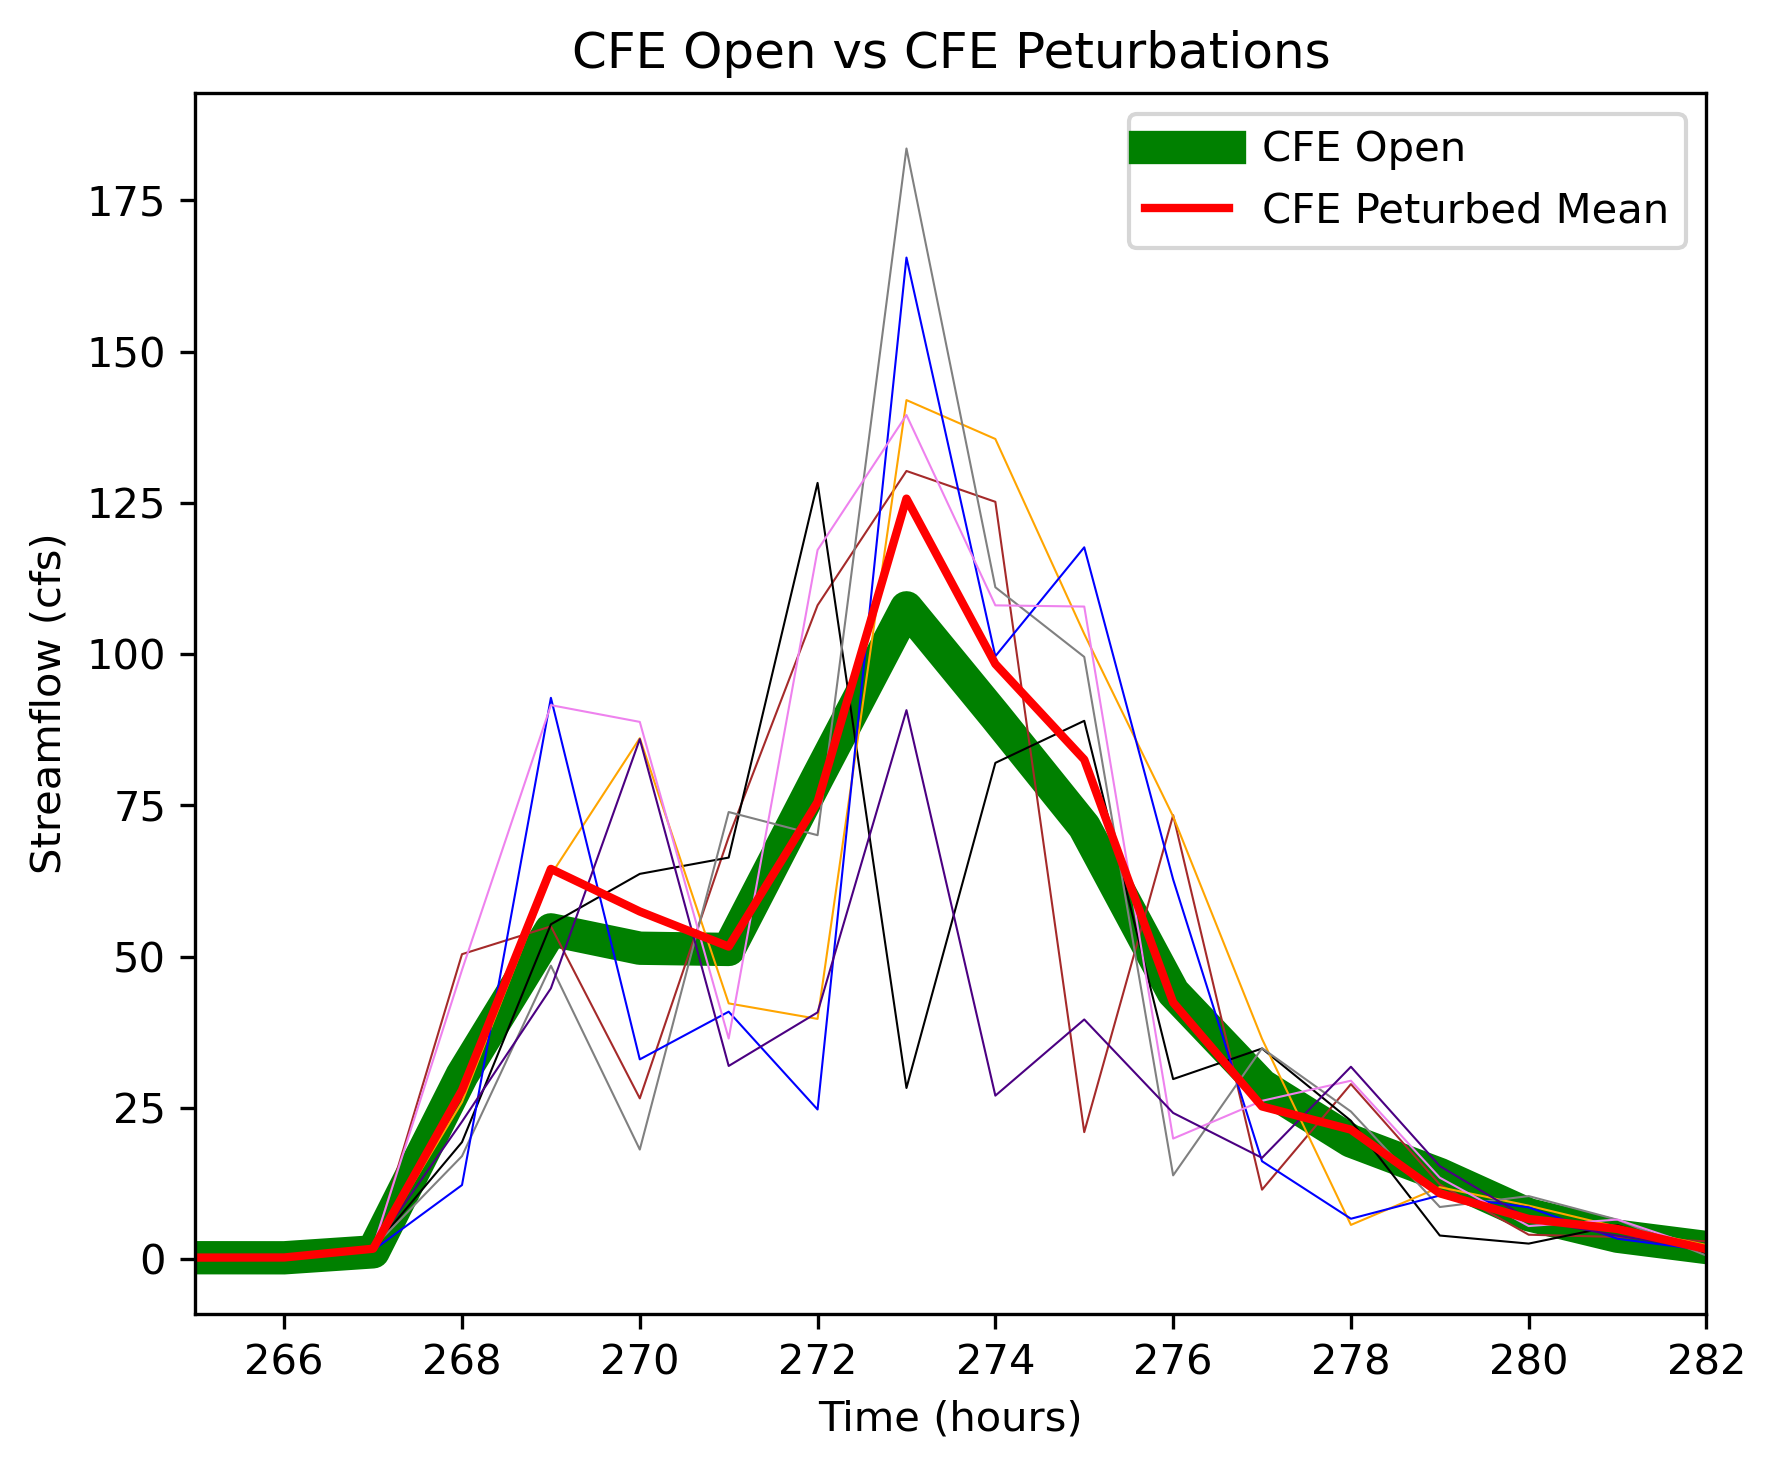

In [4]:
# Make CFE Peturbations in dataframe to plot each ensemble
cfePet_df = pd.DataFrame(cfePeturbed)

# Get time for plot
istart_plot = 265
iend_plot   = 283
x           = list(range(istart_plot, iend_plot))

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (6,5), dpi=300)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Streamflow (cfs)')
plt.title('CFE Open vs CFE Peturbations')

# Plot the variables on the plot! 
Open,        = ax1.plot(x, cfeOpen[istart_plot:iend_plot],linewidth=8, color = 'green', label = 'CFE Open')
Peturb,      = ax1.plot(x, cfePet_df[0][istart_plot:iend_plot], linewidth=0.5, color = 'brown')
Peturb,      = ax1.plot(x, cfePet_df[1][istart_plot:iend_plot], linewidth=0.5, color = 'black')
Peturb,      = ax1.plot(x, cfePet_df[2][istart_plot:iend_plot], linewidth=0.5, color = 'orange')
Peturb,      = ax1.plot(x, cfePet_df[3][istart_plot:iend_plot], linewidth=0.5, color = 'grey')
Peturb,      = ax1.plot(x, cfePet_df[4][istart_plot:iend_plot], linewidth=0.5, color = 'blue')
Peturb,      = ax1.plot(x, cfePet_df[5][istart_plot:iend_plot], linewidth=0.5, color = 'violet')
Peturb,      = ax1.plot(x, cfePet_df[6][istart_plot:iend_plot], linewidth=0.5, color = 'indigo')
Peturb_mean, = ax1.plot(x, cfePeturbed_mean[istart_plot:iend_plot], linewidth=2, color = 'red',label='CFE Peturbed Mean')

# Plot the legend and fix layout
plt.legend(handles = [Open,Peturb_mean], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("SubRegionModel.png")
plt.show()


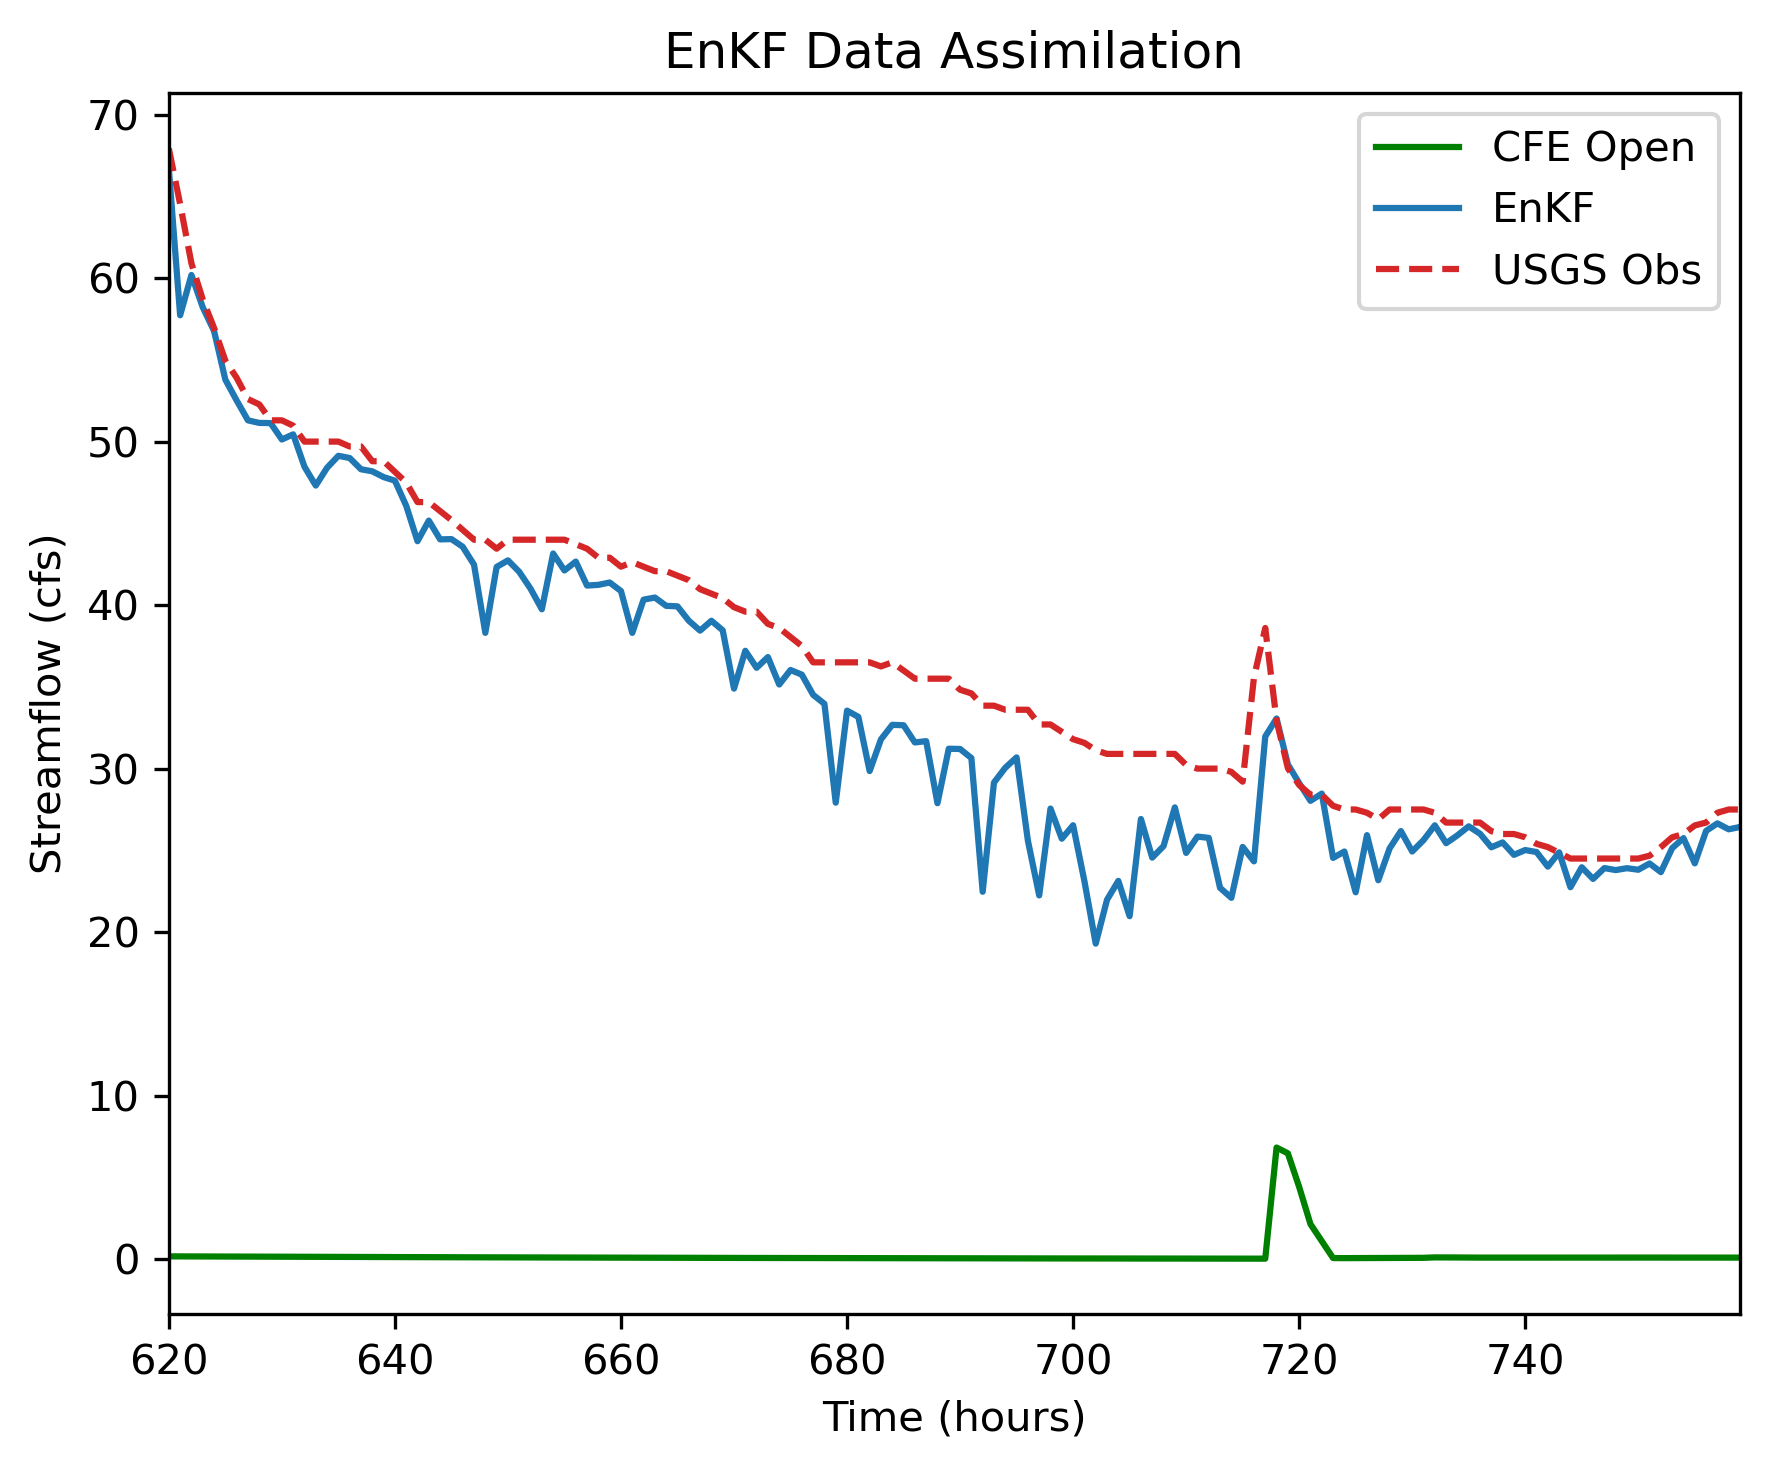

In [15]:
# Get time for plot
istart_plot=620
iend_plot=760
x = list(range(istart_plot, iend_plot))

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (6,5), dpi=300)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Streamflow (cfs)')
plt.title('EnKF Data Assimilation')

# Plot the variables on the plot! 
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot],color = 'green', label = 'CFE Open')
EnKF, = ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')
Obs,  = ax1.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Obs')

# Plot the legend and fix layout
plt.legend(handles = [Open,EnKF, Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("SubRegionModel.png")
plt.show()
